In [1]:
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil
 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
datasets = {'ml100k':'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
            'ml20m':'http://files.grouplens.org/datasets/movielens/ml-20m.zip',
            'mllatestsmall':'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
            'ml10m':'http://files.grouplens.org/datasets/movielens/ml-10m.zip',
            'ml1m':'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
            }

In [3]:
!mkdir sample_data

In [4]:
dt = "mllatestsmall"
#dt = "ml1m"
dt_name = os.path.basename(datasets[dt])
 
print('Downloading {}'.format(dt_name))
with urllib.request.urlopen(datasets[dt]) as response, open('./sample_data/'+dt_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
print('Download completed')

Download completed


In [5]:
!unzip sample_data/ml-latest-small.zip
#!unzip sample_data/ml-1m.zip
! ls -Rp .

Archive:  sample_data/ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
.:
ml-latest-small/  sample_data/

./ml-latest-small:
README.txt  links.csv  movies.csv  ratings.csv	tags.csv

./sample_data:
ml-latest-small.zip


In [6]:
dataset = pd.read_csv("./ml-latest-small/ratings.csv",sep=',',names="user_id,item_id,rating,timestamp".split(","), skiprows=1)
#dataset = pd.read_csv("./ml-1m/ratings.dat",sep='::',names="user_id,item_id,rating,timestamp".split(","), skiprows=1)
print(dataset.shape)
dataset.head()

(100836, 4)


,user_id,item_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


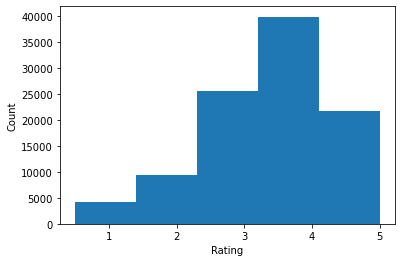

Average rating: 3.501556983616962
Median rating: 3.5


In [7]:
ratings = dataset.rating.tolist()

plt.hist(ratings, bins=5)
plt.xticks([1, 2, 3, 4, 5])
plt.ylabel('Count')
plt.xlabel('Rating')
plt.show()

print('Average rating:', np.mean(ratings))
print('Median rating:', np.median(ratings))

In [7]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [8]:
train, test = train_test_split(dataset, test_size=0.3)

In [9]:
# Ensure that train_data is not empty
if len(train) == 0:
    raise ValueError("Train data is empty. Please check the dataset.")

In [10]:
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 20

# the mlp implementation

In [12]:
keras.backend.clear_session()

movie_input = keras.layers.Input(shape=[1],name='Item')
user_input = keras.layers.Input(shape=[1],name='User')

user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors, name='User-Embedding')(user_input)
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)

user_vec_mlp = keras.layers.Flatten(name='FlattenUsersMLP')(user_embedding)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMoviesMLP')(movie_embedding)

#concatenate layer
concat = keras.layers.Concatenate(axis=-1)([user_vec_mlp, movie_vec_mlp])

# MLP layers
mlp = keras.layers.Dense(128, activation='relu', name='Dense128')(concat)
mlp = keras.layers.Dense(64, activation='relu', name='Dense64')(mlp)
mlp = keras.layers.Dense(32, activation='relu', name='Dense32')(mlp)

output = keras.layers.Dense(1, name='Output')(mlp)

model = keras.Model([user_input, movie_input], output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 20)        120820      User[0][0]                       
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 20)        74140       Item[0][0]                       
______________________________________________________________________________________________

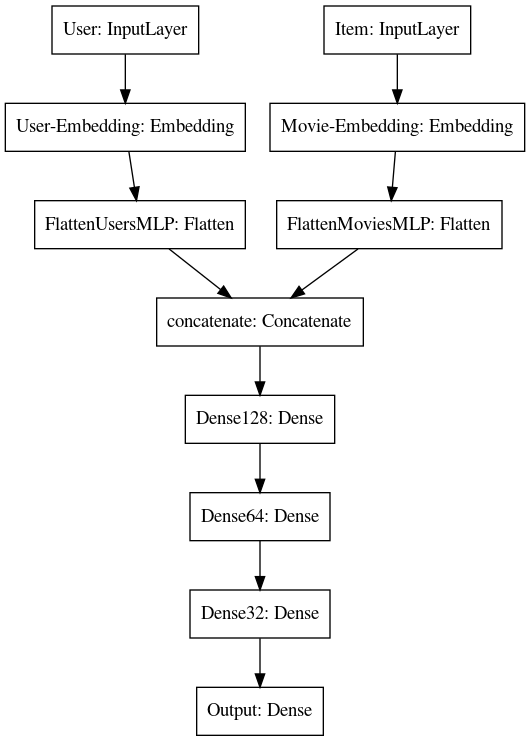

In [15]:
tf.keras.utils.plot_model(model)

In [13]:
# Convert train and test data to TensorFlow tensors
train_data = {"user_id": train["user_id"].values, "item_id": train["item_id"].values, "rating": train["rating"].values}
test_data = {"user_id": test["user_id"].values, "item_id": test["item_id"].values, "rating": test["rating"].values}

In [26]:
class HitRate(tf.keras.metrics.Metric):
    def __init__(self, k=10, name='hit_rate', **kwargs):
        super(HitRate, self).__init__(name=name, **kwargs)
        self.k = k
        self.hits = self.add_weight(name='hits', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        top_k_indices = tf.argsort(y_pred, direction='DESCENDING')[:, :self.k]
        top_k_pred = tf.reduce_sum(tf.cast(tf.gather(y_true, top_k_indices), tf.float32), axis=1)
        self.hits.assign_add(tf.reduce_sum(tf.cast(top_k_pred, tf.float32)))
        self.total.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return (self.hits / self.total)

    def reset_states(self):
        self.hits.assign(0.0)
        self.total.assign(0.0)

In [27]:
hit_rate = HitRate(k=10)

# federated loop

In [16]:
# Federated Average Gradient (FAVG) Training
def FAVG_train(server_model, train_data, server_rounds, client_epochs, batch_size, num_clients):
    
    
    # Split train_data into subsets for clients
    client_data_size = len(train_data["user_id"]) // num_clients
    clients_data = []
    for i in range(num_clients):
        start_index = i * client_data_size
        end_index = (i + 1) * client_data_size if i < num_clients - 1 else None
        client_data = {key: value[start_index:end_index] for key, value in train_data.items()}
        clients_data.append(client_data)
    
    client_metrics = {f'client_{i+1}': {'loss': [], 'mae': [], 'mse': []} for i in range(num_clients)}
    
    #train the client based on different subsets.
    for i in range(server_rounds):
        client_weights = []
        for client_idx, client_data in enumerate(clients_data):
            client_model = tf.keras.models.clone_model(server_model)
            client_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse', hit_rate])
            history = client_model.fit([client_data["user_id"], client_data["item_id"]], client_data["rating"],
                             batch_size=batch_size, epochs=client_epochs, verbose=1)
            client_weights.append(client_model.get_weights())
            # Collect training metrics from client
            
            client_loss = history.history['loss']
            client_mae = history.history['mae']
            client_mse = history.history['mse']
         
            client_metrics[f'client_{client_idx+1}']['loss'].extend(client_loss)
            client_metrics[f'client_{client_idx+1}']['mae'].extend(client_mae)
            client_metrics[f'client_{client_idx+1}']['mse'].extend(client_mse)
            
            
            print("this client completed")
            
        server_weights = np.mean(client_weights, axis=0)
        server_model.set_weights(server_weights)
        print("Round {}: Server Model Updated by Average Gradient".format(i + 1))
        
    return client_metrics


In [17]:
# Initialize server model
server_model = model

In [18]:
# training parameters
server_rounds = 1
client_epochs = 25
batch_size = 64
num_clients = 3

In [ ]:
client_metrics  = FAVG_train(server_model, train_data, server_rounds, client_epochs, batch_size, num_clients)

In [ ]:
for client_idx, metrics in client_metrics.items():
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['mae'], label='MAE')
    plt.plot(metrics['mse'], label='MSE')
    plt.title(f'Metrics for {client_idx}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [30]:
evaluation_result = server_model.evaluate([test_data["user_id"], test_data["item_id"]], test_data["rating"], batch_size=128)

# Print evaluation result
print("Evaluation Result:")
print("Loss:", evaluation_result[0])
print("MAE:", evaluation_result[1])
print("MSE:", evaluation_result[2])

2345/2345 [==============================] - 4s 2ms/step - loss: 0.4233 - mae: 0.4994 - mse: 0.4233
Evaluation Result:
Loss: 0.42334452271461487
MAE: 0.4994077682495117
MSE: 0.42334452271461487


In [31]:
def evaluate_server_model(server_model, test_data, hit_rate_metric):
    #get predication
    server_predictions = server_model.predict([test_data["user_id"], test_data["item_id"]])

    # compute the hit rate
    hit_rate_metric.reset_states()
    hit_rate_metric.update_state(test_data["rating"], server_predictions)
    server_hit_rate = hit_rate_metric.result().numpy()

    return server_hit_rate

In [32]:
server_hit_rate = evaluate_server_model(server_model, test_data, hit_rate)
print(f"Server Model Hit Rate: {server_hit_rate}")

Server Model Hit Rate: 0.5
